In [51]:
%load_ext autoreload

%autoreload 2

from glob import glob
from os.path import join
import os
import pickle

import scipy.linalg
import matplotlib
matplotlib.rcParams["figure.dpi"] = 144
matplotlib.rcParams["savefig.dpi"] = 144
import matplotlib.pyplot as plt
import numpy as np

from astropy.table import Table, Column
import astropy.units as u

import emcee

import kepler
import threebody

import minuit_wrap
%matplotlib inline

import logging


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
#d = pickle.load(open("forecaster_params.pickle"))
#d["files"] = "tuned_mueller_pulses_selected"
#d["toa_mode"] = "pipeline"
d = pickle.load(open("fitter_params.pickle"))
F = threebody.Fitter(**d)


In [3]:
res = F.residuals()

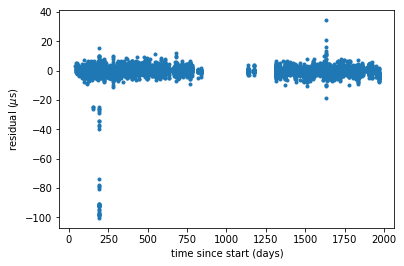

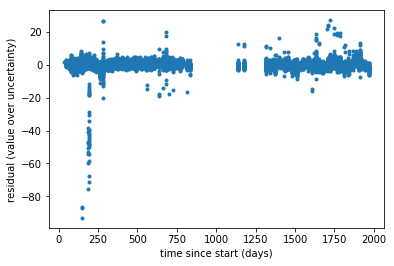

In [4]:
plt.plot(F.mjds, 1e6*res/F.reference_f0, ".")
plt.xlabel("time since start (days)")
plt.ylabel(r"residual ($\mu$s)")
plt.savefig("current-fitter-residuals.pdf")
plt.figure()
plt.plot(F.mjds, res/F.phase_uncerts, ".")
plt.xlabel("time since start (days)")
plt.ylabel(r"residual (value over uncertainty)")
plt.savefig("current-fitter-z.pdf")


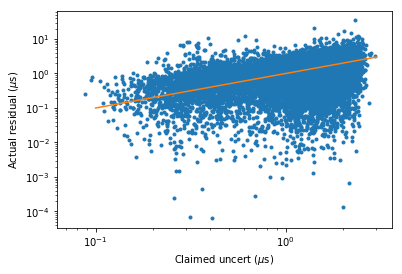

In [5]:
bot = 0.1
top = 3
plt.loglog(1e6*F.phase_uncerts/F.reference_f0, 
           1e6*res/F.reference_f0, ".")
plt.loglog([bot,top],[bot,top])
plt.xlabel(r"Claimed uncert ($\mu$s)")
plt.ylabel(r"Actual residual ($\mu$s)")
plt.savefig("uncert-vs-resid.pdf")

In [6]:
F.best_parameters

{'acosi_i': 1.4917497972525973667,
 'acosi_o': 91.537900540340523023,
 'asini_i': 1.2175268934245741167,
 'asini_o': 74.672698799442642742,
 'd_DECJ': 1.6847336940935975218e-07,
 'd_PMDEC': -1.9580532733266362e-10,
 'd_PMRA': 9.885280864586482e-11,
 'd_PX': -0.92477760701603597092,
 'd_RAJ': -3.2388334094615887816e-08,
 'dbeta': -0.00041698493776006720714,
 'delta': -3.1672615080429307528e-06,
 'delta_lan': -2.2929802725921750288e-05,
 'dgamma': 1.175749501990592583e-06,
 'eps1_i': 0.00068710702331380968213,
 'eps1_o': 0.035186237842836027508,
 'eps2_i': -9.1380827419824661545e-05,
 'eps2_o': -0.0034622142016451433639,
 'f0': 365.95336876828094,
 'general': True,
 'j_AO1350': 5.4169010371405938449e-05,
 'j_AO1440': 4.8930549945746121983e-05,
 'j_AO327': 6.5301884179095320452e-05,
 'j_GBT1500': 6.2334158805205982467e-05,
 'j_GBT350': 1.8510494219682503864e-05,
 'j_GBT820': 6.7999885696179984064e-05,
 'j_NCY1400': 0.000675,
 'j_WSRT350': -3.6586764591042250491e-05,
 'lan': 22.85420231156

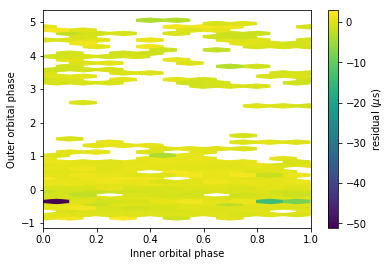

In [7]:
threebody.hexplot(F.best_parameters, F.mjds, 
                  1e6*res/F.reference_f0,
                  gridsize=(10,30))
plt.colorbar(label="residual ($\mu$s)")

## Making TOAs-with-residuals

In [32]:
toa_infos = threebody.read_t2_toas("tuned_mueller_pulses_selected.tim")
if len(toa_infos)!=len(res):
    raise ValueError
ixi = np.argsort(F.ix)
for (i,t) in enumerate(toa_infos):
    i_F = ixi[i]
    #print i, i_F, F.phase_uncerts[i_F]
    u_F = 1e6*F.phase_uncerts[i_F]/F.reference_f0
    u_t = t["uncert"]
    if np.abs(u_F - u_t)>1e-3:
        raise ValueError("Uncertainties do not agree: %g and %g"
                         % (u_F, u_t))
    t["flags"]["resid_phase"] = res[i_F]
    t["flags"]["resid_s"] = res[i_F]/F.reference_f0
    t["flags"]["day_bary"] = F.mjds[i_F]
    t["flags"]["uncert_phase"] = F.phase_uncerts[i_F]


In [33]:
threebody.write_t2_toas("tuned_mueller_pulses_selected_residuals.tim",
                        toa_infos)


In [64]:

zs = [np.abs(t["flags"]["resid_phase"]/t["flags"]["uncert_phase"])
      for t in toa_infos]
ix = np.argsort(zs)[::-1]
i = 0
files = {}
z = np.inf
while(z)>10:
    t = toa_infos[ix[i]]
    f = t["file"]
    o = f.split("/")[2]
    if o not in files:
        z = zs[ix[i]]
        files[o] = [z,
                    1e6*t["flags"]["resid_s"], 
                    t["uncert"], 
                    0]
    files[o][3] += 1        
    i += 1
    
os = []
zss = []
rs = []
us = []
ns = []
for k, v in sorted(files.items()):
    os.append(k)
    zss.append(v[0])
    rs.append(v[1])
    us.append(v[2])
    ns.append(v[3])
    
rows = [[k, v[0], v[1], v[2], v[3]] for (k,v) in sorted(files.items())]
rows.sort(key=lambda r: -r[1])
T = Table(rows=rows,
          names=["Observation", "abs(z)", 
                 "residual", "uncertainty", "n"])
T['residual'].unit = u.us
T['uncertainty'].unit = u.us
T['abs(z)'].format = ".2f"
T['residual'].format = ".3f"
T['uncertainty'].format = ".3f"
T.pprint(max_lines=-1)

   Observation     abs(z) residual uncertainty  n 
                             us         us        
------------------ ------ -------- ----------- ---
   56070.64_AO_430  93.01  -25.820       0.278   3
56109.30_WSRT_1400  75.41  -91.208       1.210   9
56111.17_WSRT_1400  71.10  -91.658       1.289  13
56112.44_WSRT_1400  50.07  -77.713       1.552   5
56113.15_WSRT_1400  29.03  -37.206       1.282  10
   57643.37_AO_430  26.87    8.302       0.309   1
  56201.32_AO_1400  26.46   10.381       0.392   8
   57628.41_AO_430  24.19    6.753       0.279   2
   57667.34_AO_430  22.02    7.624       0.346   2
   57621.43_AO_430  21.29    6.168       0.290   1
  56599.21_AO_1400  19.54   11.882       0.608   3
   57686.26_AO_430  19.35    6.519       0.337   2
   56554.36_AO_430  19.06   -5.056       0.265   2
   57705.21_AO_430  18.84    6.466       0.343   2
   57551.62_AO_430  18.43    6.271       0.340   2
   56620.16_AO_430  17.95   -4.626       0.258   1
   56736.87_AO_430  16.69   -4.

In [39]:
np.argsort?

## What's in the raw data

In [16]:
gbt_mjds = set()
ao_mjds = set()

for d in ["/data1/GBT/0337+17", "/data1/GBT/0337+17/new"]:
    for f in glob(join(d,"guppi_*")):
        mjd = int(f.split("_")[1])
        gbt_mjds.add(mjd)

a = np.array(sorted(gbt_mjds))
print a
print np.array(zip(a[:-1], np.diff(a), a[1:]))


[55953 55955 55957 55959 55962 55963 55966 55970 55973 55976 55978 55986
 55992 55994 55997 55998 55999 56003 56005 56006 56009 56014 56018 56021
 56028 56031 56034 56036 56039 56041 56044 56047 56050 56053 56056 56060
 56063 56066 56069 56071 56081 56096 56101 56103 56107 56116 56121 56124
 56128 56131 56135 56142 56145 56149 56158 56163 56170 56175 56179 56187
 56197 56203 56207 56214 56223 56234 56236 56241 56246 56274 56276 56283
 56290 56297 56304 56311 56320 56328 56333 56340 56346 56353 56362 56367
 56376 56381 56382 56389 56398 56405 56406 56412 56416 56423 56430 56437
 56444 56458 56465 56471 56479 56487 56494 56500 56506 56515 56523 56527
 56550 56563 56585 56595 56599 56603 56611 56622 56630 56639 56649 56660
 56668 56684 56689 56690 56702 57236 57249 57262 57280 57292 57301 57322
 57343 57354 57364 57384 57405 57412 57428 57448 57470 57471 57493 57510
 57532 57538 57558 57577 57591 57599 57621 57636 57642 57660 57678 57697
 57700 57720 57740 57756 57761 57782 57805 57825 57